In [1]:
# Importing required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install yfinance
import yfinance as yf

#### a) Data Collection and Plotting

In [2]:
# Downloading dataset from Yahoo Finance

btc = yf.download("BTC-USD", start='2024-04-01',end='2024-04-02', interval='1m')
ltc = yf.download("LTC-USD",start='2024-04-01',end='2024-04-02', interval='1m')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
# Aligning btc and ltc closing prices sice their sizes are not equal

merged_data = pd.merge(btc['Adj Close'], ltc['Adj Close'], how='outer', left_index=True, right_index=True)
merged_data.ffill(inplace=True)  # Forward-fill missing values (if any)
merged_data.bfill(inplace=True)  # Backward-fill any remaining missing values (if any)
merged_data

,Adj Close_x,Adj Close_y
Datetime,,
2024-04-01 00:00:00+00:00,71312.171875,105.172768
2024-04-01 00:01:00+00:00,71211.929688,105.107903
2024-04-01 00:03:00+00:00,71197.742188,105.017784
2024-04-01 00:04:00+00:00,71240.101562,104.860443
2024-04-01 00:05:00+00:00,71263.460938,104.875771
...,...,...
2024-04-01 23:54:00+00:00,69753.195312,99.633232
2024-04-01 23:55:00+00:00,69762.085938,99.507622
2024-04-01 23:56:00+00:00,69734.414062,99.498169


In [4]:
p1=merged_data.iloc[:,0]   # minutely closing prices of Bitcoin after aligning
p2=merged_data.iloc[:,1]   # minutely closing prices of Litecoin after aligning

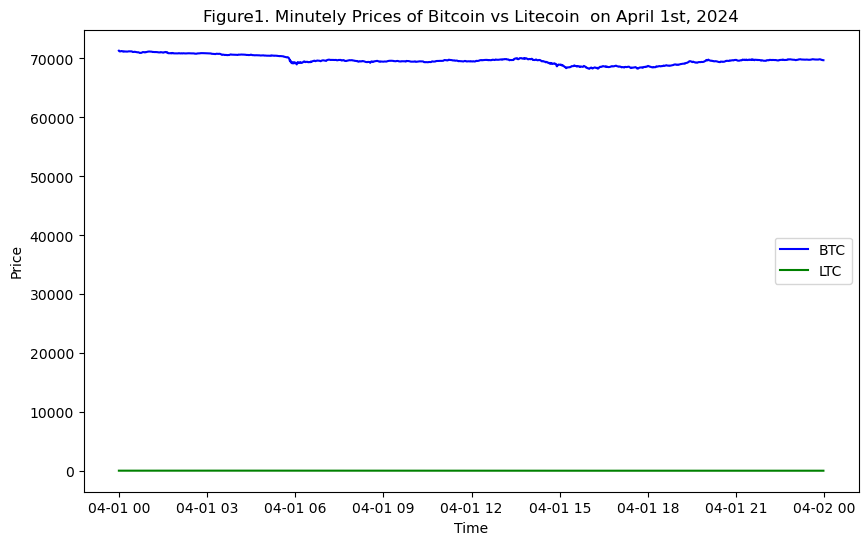

In [5]:
# Plotting minutely prices

plt.figure(figsize=(10, 6))
plt.plot(p1.index, p1, color='blue', label='BTC')
plt.plot(p2.index, p2, color='green', label='LTC')
plt.title('BTC vs LTC')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Figure1. Minutely Prices of Bitcoin vs Litecoin  on April 1st, 2024')
plt.legend()
plt.show()


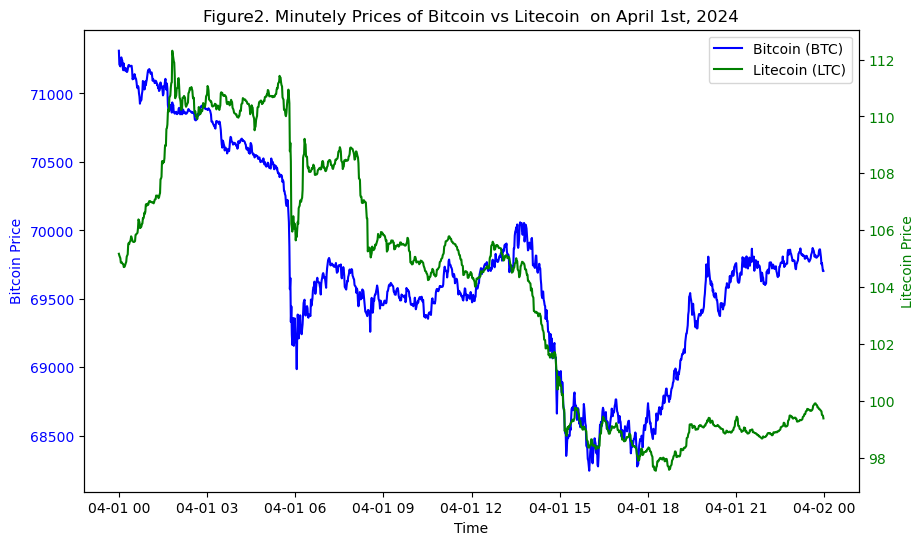

In [6]:
# Plotting minutely prices with different axis

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Bitcoin prices on the left axis
ax1.plot(p1.index, p1, color='blue', label='Bitcoin (BTC)')
ax1.set_xlabel('Time')
ax1.set_ylabel('Bitcoin Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylabel('Bitcoin Price', color='blue')

# Create a secondary y-axis for Litecoin prices
ax2 = ax1.twinx()
ax2.plot(p2.index, p2, color='green', label='Litecoin (LTC)')
ax2.set_ylabel('Litecoin Price', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Figure2. Minutely Prices of Bitcoin vs Litecoin  on April 1st, 2024')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper right')
plt.show()

#### b) Evaluating Rho

In [7]:
r1=np.log(p1/p1.shift(1))
r2=np.log(p2/p2.shift(1))

In [8]:
delta=1
rho=r1.corr(r2)
print(f"Correlation Coefficient (Rho) is: {rho:.4f}")

Correlation Coefficient (Rho) is: 0.2182


#### c) Evaluating Beta

In [9]:
from scipy.stats import linregress
result=linregress(np.log(p1),np.log(p2))
beta=result.slope
print(f"The Coefficient Beta is: {beta:.4f}")

The Coefficient Beta is: 2.9209


#### d) Evaluating Mean and Std Deviation

In [10]:
mu_1 = r1.mean()*1440
mu_2 = r2.mean()*1440
sigma_1 = r1.std()*np.sqrt(1440)
sigma_2 = r2.std()*np.sqrt(1440)

In [11]:
print(f"The mean log returns of BTC is: {mu_1:.4f}")
print(f"The mean log returns of LTC is: {mu_2:.4f}")
print(f"The standard deviation of BTC is: {sigma_1:.4f}")
print(f"The standard deviation of LTC is: {sigma_2:.4f}")

The mean log returns of BTC is: -0.0230
The mean log returns of LTC is: -0.0570
The standard deviation of BTC is: 0.0223
The standard deviation of LTC is: 0.0513


#### e) Evaluating Trading Weights (Pi)

In [12]:
gamma = 0.5
delta=1
T=1
M=len(p1)
dt = T/M
eta = (-1/delta) * (mu_1 - sigma_1 ** 2/2 + beta*(mu_2 - sigma_2 ** 2/2))
sigma_beta = np.sqrt(sigma_1 ** 2 + beta ** 2 * sigma_2 ** 2 + 2 * beta * sigma_1 * sigma_2 * rho)

In [15]:
S1_0 = p1[0]
S2_0 = p2[0]
z_0 = 0
S1 = np.zeros((M + 1, 1))
S2 = np.zeros((M + 1, 1))
z =  np.zeros((M + 1, 1))
a =  np.zeros((M + 1, 1))
b =  np.zeros((M + 1, 1))
c =  np.zeros((M + 1, 1))
Pi_1 = np.zeros((M + 1, 1))
Pi_2 = np.zeros((M + 1, 1))
tt = np.linspace(0, 1, M + 1)
z[0] = z_0
S1[0] = S1_0
S2[0] = S2_0
rn = np.random.standard_normal(z.shape)
rn1 = np.random.standard_normal(S1.shape) 
rn2 = np.random.standard_normal(S2.shape) 
for t in range(1, M + 1):
    z[t] = z[t-1]* (1 - delta * (eta - z[t-1])) * dt + sigma_beta * np.sqrt(dt)*((sigma_1 + beta * sigma_2 * rho)/ sigma_beta * rn1[t] + beta * (sigma_2 * np.sqrt(1-rho ** 2)/sigma_beta) * rn1[t]);
    S1[t] = S1[t-1] * np.exp((mu_1 + delta * z[t] - sigma_1 ** 2 / 2) * dt + sigma_1 * np.sqrt(dt) * rn1[t])
    S2[t] = S2[t-1] * np.exp((mu_2 - sigma_2 ** 2 / 2) * dt + sigma_2 * np.sqrt(dt) * (rho * rn1[t] + np.sqrt(1 - rho ** 2) * rn2[t]))

In [17]:
for t in range(1, M):
    z[t] = z[t-1]* (1 - delta * (eta - z[t-1])) * dt + sigma_beta * np.sqrt(dt)*((sigma_1 + beta * sigma_2 * rho)/ sigma_beta * rn1[t] + beta * (sigma_2 * np.sqrt(1-rho ** 2)/sigma_beta) * rn1[t]);
    a[t] = 0.5 * (T - t * dt)/((1-rho ** 2) * sigma_1 ** 2)
    b[t] = - 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2)/((1 - rho ** 2) * sigma_1 ** 2) - rho * mu_2 * (T - t * dt)/((1 - rho **2) * sigma_1 * sigma_2)
    c[t] = 0.5 * mu_2 ** 2 * (T - t * dt)/((1 - rho ** 2) * sigma_2 ** 2) + 0.25 * (T - t * dt) ** 2 * (sigma_1 ** 2 + beta * sigma_2 ** 2 + 2 * sigma_1 * sigma_2 * beta *rho) * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2) + 0.25 * (T - t * dt) ** 2 * mu_2 * delta * rho * (sigma_1 ** 2 + beta * sigma_2 ** 2) + 1/24 * (T - t * dt) ** 3 * (sigma_1 ** 2 + beta * sigma_2 ** 2) ** 2 * delta ** 2/((1 - rho ** 2) * sigma_1 ** 2)
    Pi_1[t] = (1 / S1[t]) * ((mu_1 + delta * z[t])/(gamma * (1 - rho ** 2) * sigma_1 ** 2) + delta/gamma * (-2 * a[t] * (mu_1 + delta * z[t])-b[t]) - rho * mu_2/(gamma * (1 - rho ** 2) * sigma_1 * sigma_2))
    Pi_2[t] = (1 / S2[t]) * (mu_2 / (gamma * (1 - rho ** 2) * sigma_2 ** 2) + delta * beta / gamma * (- 2 * a[t] * (mu_1 + delta * z[t]) - b[t]) - rho * (mu_1 + delta * z[t]) / (gamma * (1 - rho ** 2) * sigma_1 * sigma_2))

Text(0.5, 1.0, 'Weights')

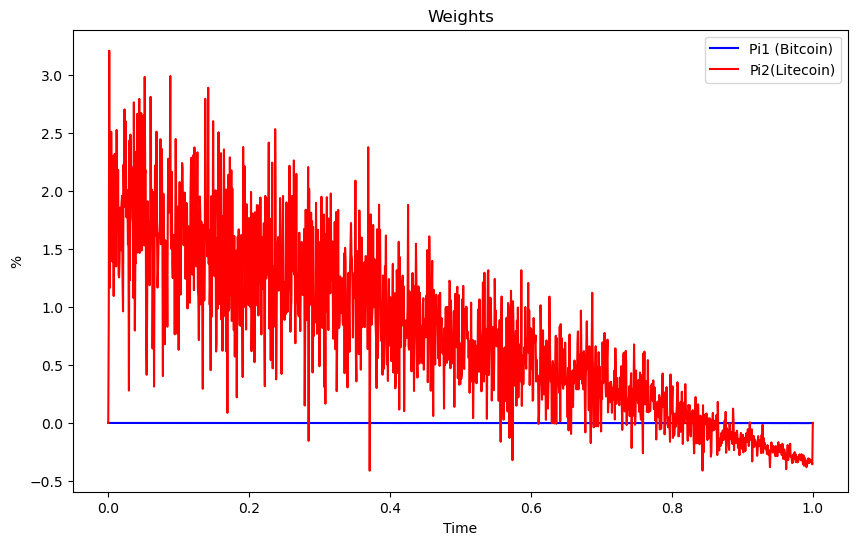

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(tt, Pi_1, 'b', lw=1.5, label='Pi1 (Bitcoin)')
plt.plot(tt, Pi_2, 'r', lw=1.5, label='Pi2(Litecoin)')
plt.legend(loc=0)
plt.xlabel('Time')
plt.ylabel('%')
plt.title('Weights')

In [23]:
Pi_1

array([[ 0.        ],
       [ 0.00012004],
       [ 0.00011805],
       ...,
       [-0.00147788],
       [-0.00098253],
       [ 0.        ]])

In [24]:
Pi_2

array([[ 0.        ],
       [ 0.859212  ],
       [ 3.20913222],
       ...,
       [-0.32312365],
       [-0.35648639],
       [ 0.        ]])